# SYS 611: Queuing Model (with Balking)

Paul T. Grogan <pgrogan@stevens.edu>

This example constructs a simulation model for a single-server queuing system with balking behavior using the event-centric perspective.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy` and `matplotlib.pyplot` libraries.

In [4]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib.pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

## Process Generators

The two process generators that are required to model a simple queuing system are the inter-arrival (time between customer arrivals) and service duration. While not required for the general model, both are represented here as exponentially-distributed random variables.

In [22]:
_lambda = 1/1.5 # arrival rate, 1.5 minutes per customer or 2/3 customer per minute
_mu = 1/0.75 # service rate, 0.75 minutes per customer or 4/3 customer per minute

# define process generator for inter-arrival duration
def gen_t_arrival():
    r = np.random.rand()
    return -np.log(1-r)/_lambda
    """
    # alternatively, this function could be replaced by the following:
    return np.random.exponential(scale=1/_lambda)
    """

# define process generator for service duration
def gen_t_service():
    r = np.random.rand()
    return -np.log(1-r)/_mu
    """
    # alternatively, this function could be replaced by the following:
    return np.random.exponential(scale=1/_mu)
    """
    
# define process generator for balk
def gen_balk(N):
    r = np.random.rand()
    if N > 5 and r < 0.5:
        return True
    else:
        return False

## State Transition Function

The state transition function processes the model logic. This function computes updates to *all* simulation variables.

In [23]:
def _delta(t, N, t_A, t_D, N_A, N_B, N_D, W):
    # update the total waiting time
    W += N*(min(t_A, t_D) - t)
    # update the simulation time
    t = min(t_A, t_D)
    if t_A <= t_D:
        # check for balk
        if gen_balk(N):
            # this is a balk, only increment the balk variable
            N_B += 1
        else:
            # this is an arrival - increment the state variable
            N += 1
            # record an arrival
            N_A += 1
            if N <= 1:
                # schedule the departure
                t_D = t + gen_t_service()
        # schedule another arrival as long as t < 1000 minutes
        t_A = t + gen_t_arrival() if t < 1000 else np.inf
    else:
        # this is a departure - decrement the state variable
        N -= 1
        # record a departure
        N_D += 1
        # schedule the next departure if there are more in the system
        t_D = t + gen_t_service() if N > 0 else np.inf
    return t, N, t_A, t_D, N_A, N_B, N_D, W

## Simulation

Generate a state trajectory for a specified number of state transitions.

         i         t       t_A       t_D         N       N_A       N_D       N_B
      0.00      0.84       inf         0         0         0         0      0.00
      0.84      0.91      1.00         1         1         0         0      0.00
      0.91      2.82      1.00         2         2         0         0      0.07
      1.00      2.82      1.11         1         2         1         0      0.25
      1.11      2.82       inf         0         2         2         0      0.36
      2.82      2.93      3.41         1         3         2         0      0.36
      2.93      6.54      3.41         2         4         2         0      0.47
      3.41      6.54      4.61         1         4         3         0      1.43
      4.61      6.54       inf         0         4         4         0      2.63
      6.54      7.62      7.65         1         5         4         0      2.63
      7.62      9.02      7.65         2         6         4         0      3.71
      7.65      9.02      8.

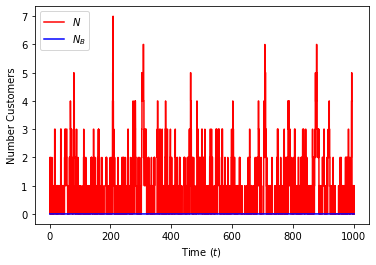

In [32]:
# initialize variables
t = 0 # simulation time
t_A = gen_t_arrival() # time of next customer arrival
t_D = np.inf # time of next customer departure
N = 0 # number of customers in the queuing system
N_A = 0 # cumulative number of arrivals
N_B = 0 # cumulative number of balks
N_D = 0 # cumulative number of departures
W = 0 # cumulative waiting time

# initialize data lists for plotting
plot_t = [] # simulation time
plot_B = [] # number of balks
plot_N = [] # number of customers in the queuing system


print('{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}{:>10s}'.format(
        'i', 't', 't_A', 't_D', 'N', 'N_A', 'N_D', 'N_B', 'W'))
print('{:10.2f}{:10.2f}{:10.2f}{:10.0f}{:10.0f}{:10.0f}{:10.0f}{:10.2f}'.format(
        t, t_A, t_D, N, N_A, N_D, N_B, W))

# loop until simulation ends
while t_A < np.inf or t_D < np.inf:
    t, N, t_A, t_D, N_A, N_B, N_D, W = _delta(t, N, t_A, t_D, N_A, N_B, N_D, W)
    
    # append data for plotting
    plot_t.append(t)
    plot_B.append(N_B)
    plot_N.append(N)
    
    if t < 10:
        # display current state for the first 10 minutes
        print('{:10.2f}{:10.2f}{:10.2f}{:10.0f}{:10.0f}{:10.0f}{:10.0f}{:10.2f}'.format(
                t, t_A, t_D, N, N_A, N_D, N_B, W))

# print key summary statistics
print('W_bar = {:.2f}'.format(W/N_A))

# plot the state trajectory
plt.figure()
plt.step(plot_t, plot_N, '-r', label="$N$", where='post')
plt.step(plot_t, plot_B, '-b', label="$N_B$", where='post')
plt.xlabel('Time ($t$)')
plt.ylabel('Number Customers')
plt.legend(loc='best')
plt.show()